description 페이지를 보고 이번 프로젝트의 목표가 서울의 기상데이터를 통해 따릉이 대여량을 예측하는 것임을 확인했습니다.


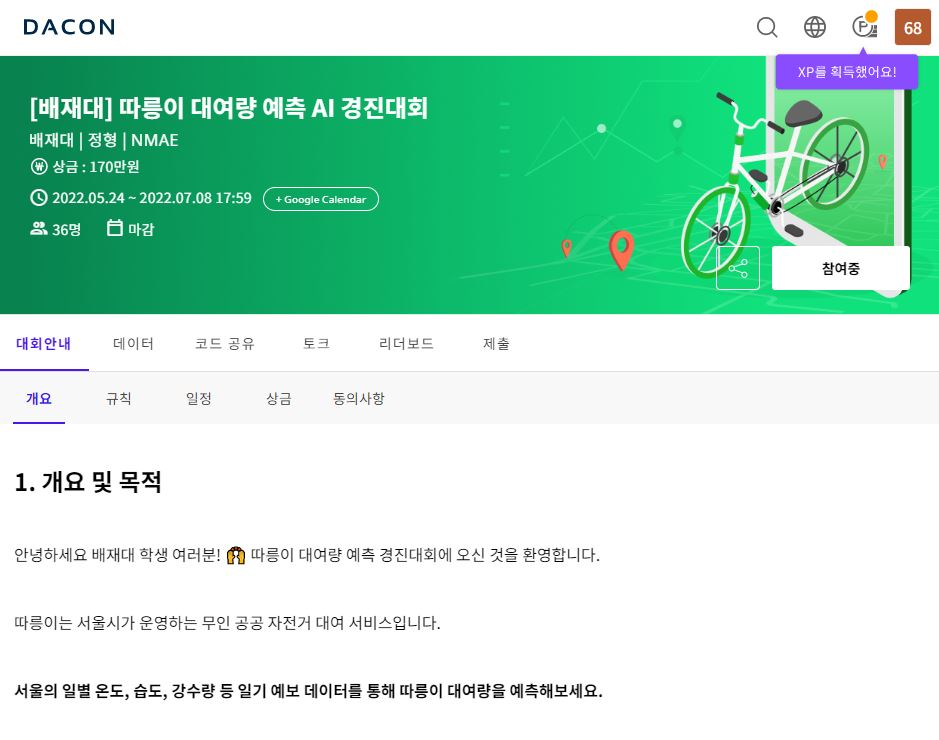

data 페이지를 보고 train.csv의 'rentals'가 따릉이 대여량임을 확인했습니다.

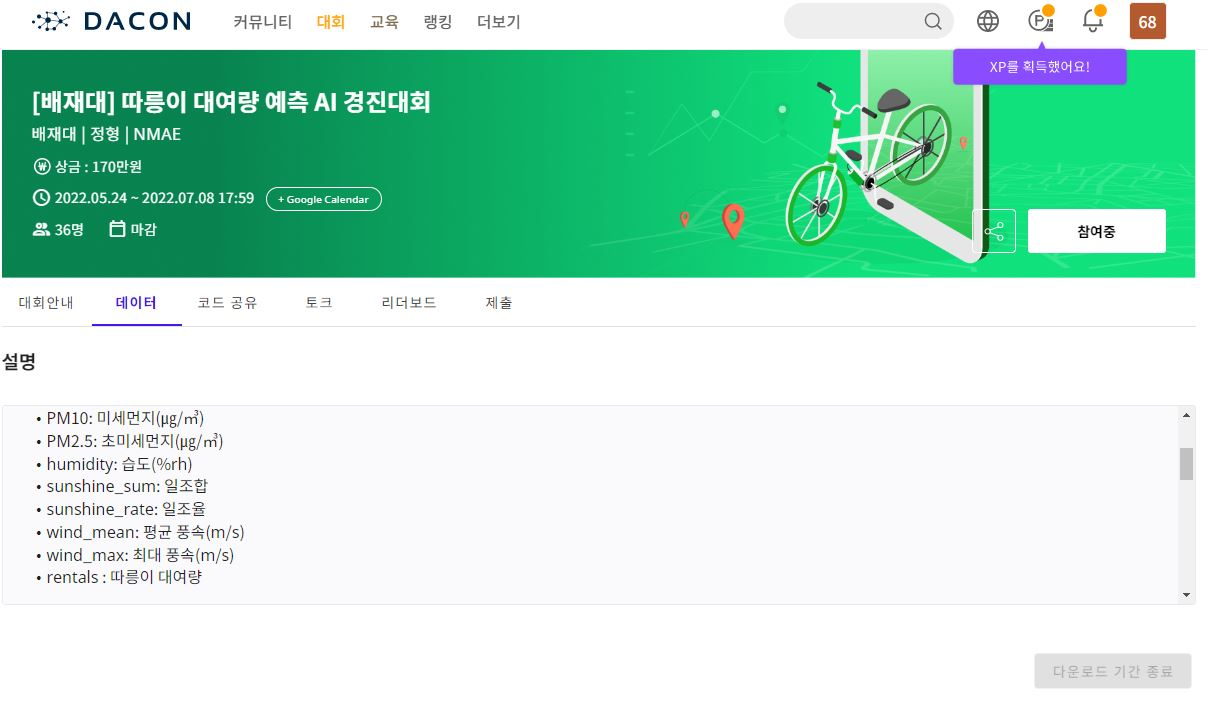

 data 페이지의 Airtable을 보고 rentals가 아닌 'rental'이 numerical target임을 확인했습니다.

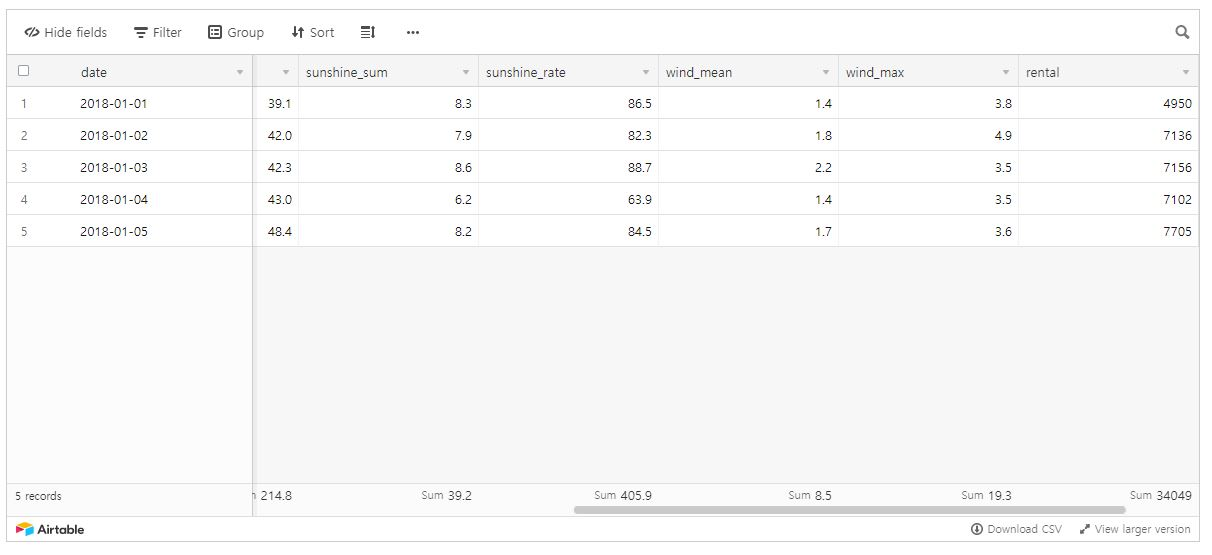

read_csv()는 파일의 첫 번째 행을 column names로 추론하기 때문에 header가 없으면 첫 번째 sample이 column names가 되는 issue가 생깁니다. 이를 미연에 방지하기 위해 data 페이지에서 다운로드 받은 dataset을 구글 drive에 업로드하고 dataset의 header 유무를 drive에서 확인했습니다.

* https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
* https://stackoverflow.com/questions/71492444/loading-a-csv-file-with-no-header-on-my-colab-by-pandas-read-csv-and-numpy-loadt

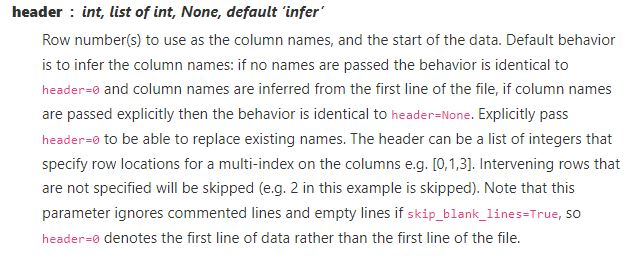

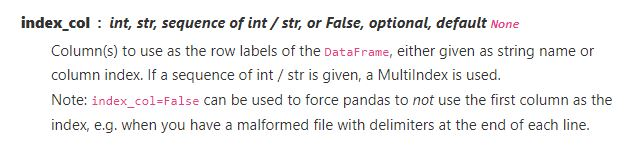

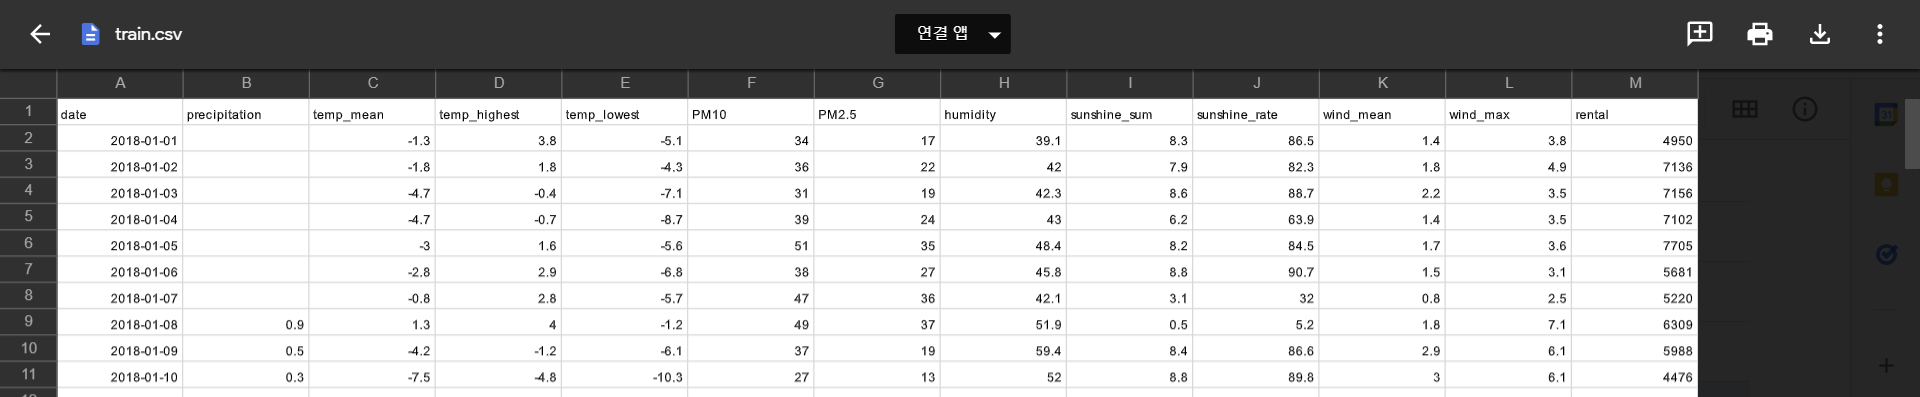

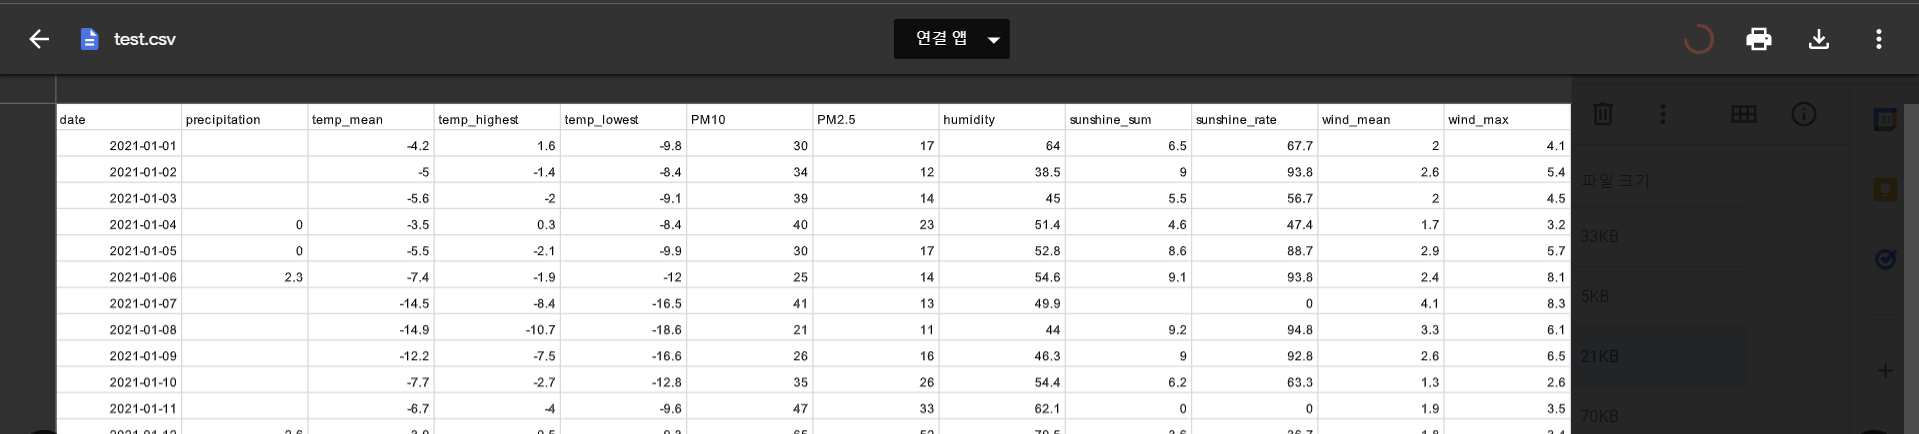

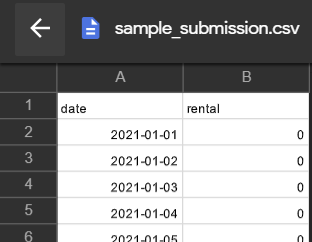

In [1]:
from google.colab import drive
drive.mount('/content/mydrive/')

Mounted at /content/mydrive/


In [2]:
import pandas as pd

train = pd.read_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/given-datasets/train.csv')
test = pd.read_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/given-datasets/test.csv')

## I. 전처리
01. PM10 : dropna(axis=0)
02. PM2.5 : dropna(axis=0)
03. sunshine_sum : fillna(0)
04. precipitation : fillna(0)
05. date : to_datetime()
06. year : dt.year
07. month : dt.month
08. day : dt.day
09. day_of_week : dt.dayofweek
10. mon : one hot encoded day of week 0
11. tue : one hot encoded day of week 1
12. wed : one hot encoded day of week 2
13. thur : one hot encoded day of week 3
14. fri : one hot encoded day of week 4
15. sat : one hot encoded day of week 5
16. sun : one hot encoded day of week 6
17. particulates10 : 미세먼지 예보 등급
18. particulates25 : 초미세먼지 예보 등급
19. particulates : 미세먼지 등급과 초미세먼지 등급 중 더 높은 등급
20. rental : astype(float)



결측치가 있는 데이터를 다뤄본 경험이 없어서 처리 방법에 대해 공부하며 배운 방법론을 적용했습니다. 
* https://www.kaggle.com/code/alexisbcook/missing-values
* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html
* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html#pandas.DataFrame.fillna

### I.1. 미세먼지 결측치
학습용 자료와 평가용 자료의 결측치를 비교했습니다. 그 결과 학습용 자료에만 미세먼지와 초미세먼지 결측치가 있었습니다. 그래서 해당 표본을 학습용 자료로부터 제거했습니다.

In [3]:
train.dropna(axis=0, subset=['PM10', 'PM2.5'], inplace=True)

### I.2. 일조합 결측치
일조합 결측치가 있는 표본을 관찰했습니다. 그 결과 모두 일조율값이 0임을 확인할 수 있었습니다. 그래서 일조율이 0인 모든 표본의 통계치를 확인해보았습니다. 해당 통계치에서 일조합의 개수와 일조율의 개수가 다르고 일조합의 최소값과 최대값이 0으로 같음을 확인할 수 있었고 이로부터 일조율 값이 0인 모든 포본은 일조합 값이 NaN 또는 0이다라는 결론을 얻었습니다. 이에 입각하여 일조합의 결측값이 NaN이면 모순이므로 일조합 결측값을 0으로 채워 넣었습니다.

In [4]:
train['sunshine_sum'].fillna(0, inplace=True)
test['sunshine_sum'].fillna(0, inplace=True)

### I.3. 강수량 결측치
precipitation 결측값을 강수량이 없는 날이라고 추측했습니다. 하지만 확인 결과 precipitation column에는 0이라는 값이 존재했습니다. 그래서 기상청 날씨 누리 페이지의 각주 "자료가 공백인 곳은 관측하지 않은 지점들입니다"를 참고하여 관측자가 관측하지 않았을 이유에 대해 생각해보았습니다. 강수량이 없는 날을 관측하지 않은 것으로 처리하면 기록업무의 품을 줄일 수 있기 때문이 아닐까라고 추측했습니다. 그리고 0이라는 값과 결측값이 공존하는 이유는 관측자가 한명 이상이라면 강수량이 없는 날을 두가지 방법으로 처리한 자료에 대해 충분한 설명이 된다고 생각하여 강수량 결측치를 0으로 채워 넣었습니다.
* https://www.weather.go.kr/w/obs-climate/land/past-obs/obs-by-element.do?stn=108&yy=2018&obs=21

In [5]:
train['precipitation'].fillna(0, inplace=True)
test['precipitation'].fillna(0, inplace=True)

### I.3. 날짜 처리
pbl 입문반 코드를 참고하여 date 열을 datetime으로 변환했습니다. 년, 월, 일을 코드 한줄로 추출할 수 있고 해당 일자의 요일 또한 쉽게 구할 수 있기 때문에 변환했습니다. 탐색적 자료 분석결과 연도별, 일별, 요일별로 서로 다른 분포를 확인하고 이를 feature에 포함시켰습니다.
* https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
* https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.year.html
* https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.month.html
* https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.day.html
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.dayofweek.html#pandas-series-dt-dayofweek

In [6]:
def split_datetime(data):
    data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day_of_week'] = data['date'].dt.dayofweek
    return data

train = split_datetime(train)
test = split_datetime(test)

0부터 6까지의 정수로 저장된 요일을 원핫인코딩 처리 했습니다. 요일의 순서에는 의미가 있지만 상대적인 크기에는 의미가 없는 범주형 자료이기 때문에 변환을 했습니다.
* https://www.kaggle.com/code/alexisbcook/categorical-variables

In [7]:
from sklearn.preprocessing import OneHotEncoder

def encode_dow(data):
    oh = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoded_dow = pd.DataFrame(oh.fit_transform(data[['day_of_week']]),
                           index=data.index,
                           columns=['mon', 'tue', 'wed', 'thur', 'fri', 'sat', 'sun'])
    data = pd.concat([data, encoded_dow], axis=1)
    return data

train = encode_dow(train)
test = encode_dow(test)

### I.4. 미세먼지 등급
미세먼지 예보 등급표를 기준으로 각각의 표본에 미세먼지 등급과 초미세먼지 등급을 부여하고 더 높은 등급을 pariculates에 0부터, 좋음 to 매우나쁨, 3까지의 정수로 저장했습니다. 상대적인 크기에 의미가 있어서 인코딩 처리를 하지 않았습니다.
* https://easylaw.go.kr/CSP/OnhunqueansInfoRetrieve.laf?onhunqnaAstSeq=96&onhunqueSeq=5499


In [8]:
import numpy as np

def grade_particulates(data):
    data['particulates10'] = np.nan
    data.loc[data['PM10'] < 151, 'particulates10'] = 2
    data.loc[data['PM10'] < 81, 'particulates10'] = 1
    data.loc[data['PM10'] < 31, 'particulates10'] = 0
    data['particulates10'].fillna(3, inplace=True)

    data['particulates25'] = np.nan
    data.loc[data['PM2.5'] < 151, 'particulates25'] = 2
    data.loc[data['PM2.5'] < 81, 'particulates25'] = 1
    data.loc[data['PM2.5'] < 31, 'particulates25'] = 0
    data['particulates25'].fillna(3, inplace=True)

    data['particulates'] = np.where(data['particulates10'] >= data['particulates25'],
                                    data['particulates10'],
                                    data['particulates25'])
    return data

train = grade_particulates(train)
test = grade_particulates(test)

### I.5. 계절
탐색적 자료 분석결과 계절별로 렌탈계 분포가 상이함을 확인할 수 있었습니다. 계절별 렌탈계 평균을 비교했을 때, 겨울이 가장 적고 가을이 가장 많음을 확인했습니다. 이에 근거하여 겨울의 계절값을 최소값인 1로, 가을의 계절값을 최대값인 4로 지정했습니다. 월을 계절에 mapping하는 딕셔너리를 사용하여 모든 표본에 계절을 부여했습니다.

In [9]:
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
month_to_season = dict(zip(range(1,13), seasons))

train['season'] = train['month'].map(month_to_season)
test['season'] = test['month'].map(month_to_season)

### I.6. 따릉이 대여량
초중급반 pbl 교육에서 중식계와 석식계 모두 float였다는 점에 근거하여 변환했습니다. 두 가지 모두 현실적으로 target이 정수를 벗어나지 않지만 변환했습니다.


In [10]:
train['rental'] = train['rental'].astype(float)

## II. 학습

In [11]:
features = ['precipitation',
            'temp_mean',
            'temp_highest',
            'temp_lowest',
            'PM10',
            'PM2.5',
            'humidity',
            'sunshine_sum',
            'sunshine_rate',
            'wind_mean',
            'wind_max',
            'year',
            'month',
            'day_of_week',
            'particulates',
            'season']

In [12]:
from sklearn.utils import shuffle

train = shuffle(train)
y = train.rental
X = train[features]

extreme gradient boosting 모델이 튜닝된 random forest 모델보다 성능이 더 우수함을 검증하고 XGBRegressor를 선택했습니다.
* https://www.kaggle.com/code/irumkim/exercise-introduction?scriptVersionId=97557384
* https://www.kaggle.com/code/alexisbcook/xgboost
* https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst

In [13]:
from xgboost.sklearn import XGBRegressor

test_model = XGBRegressor(colsample_bytree=0.7,
                       learning_rate=0.03,
                       max_depth=5,
                       min_child_weight=4,
                       n_estimators=500,
                       nthread=4,
                       objective='reg:squarederror',
                       silent=1,
                       subsample=0.7)
test_model.fit(X, y)

XGBRegressor(colsample_bytree=0.7, learning_rate=0.03, max_depth=5,
             min_child_weight=4, n_estimators=500, nthread=4,
             objective='reg:squarederror', silent=1, subsample=0.7)

## III. 후처리
* rentals : to_csv()

In [14]:
submission = pd.read_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/given-datasets/sample_submission.csv')
submission['rental'] = test_model.predict(test[features])
submission.to_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/submissions/submission-2022-07-13-ik.csv', index=False)

## IV. 환경

In [15]:
pd.show_versions(as_json=False)

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)



INSTALLED VERSIONS
------------------
commit           : 66e3805b8cabe977f40c05259cc3fcf7ead5687d
python           : 3.7.13.final.0
python-bits      : 64
OS               : Linux
OS-release       : 5.4.188+
Version          : #1 SMP Sun Apr 24 10:03:06 PDT 2022
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : None
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 1.3.5
numpy            : 1.21.6
pytz             : 2022.1
dateutil         : 2.8.2
pip              : 21.1.3
setuptools       : 57.4.0
Cython           : 0.29.30
pytest           : 3.6.4
hypothesis       : None
sphinx           : 1.8.6
blosc            : None
feather          : 0.4.1
xlsxwriter       : None
lxml.etree       : 4.2.6
html5lib         : 1.0.1
pymysql          : None
psycopg2         : 2.7.6.1 (dt dec pq3 ext lo64)
jinja2           : 2.11.3
IPython          : 5.5.0
pandas_datareader: 0.9.0
bs4              : 4.6.3
bottleneck       : N

- xgboost                       0.90

In [16]:
!cat /etc/issue.net

Ubuntu 18.04.5 LTS


In [17]:
import platform

platform.platform()

'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic'